In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

In [4]:
#Read the ticket from CSV files
tickets = pd.read_csv('ICM Data.csv', encoding = "ISO-8859-1")
tickets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376 entries, 0 to 375
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   ID                          376 non-null    int64 
 1   State                       376 non-null    object
 2   Title                       376 non-null    object
 3   Title Main Word             376 non-null    object
 4   Owning Service              376 non-null    object
 5   Owning Team                 376 non-null    object
 6   DIG Engineering/Infra Task  376 non-null    object
 7   Incident Manager            376 non-null    object
 8   Communications Manager      376 non-null    object
dtypes: int64(1), object(8)
memory usage: 26.6+ KB


In [5]:
tickets[:].nunique()

ID                            371
State                           2
Title                         233
Title Main Word                16
Owning Service                  1
Owning Team                     1
DIG Engineering/Infra Task     12
Incident Manager                1
Communications Manager          1
dtype: int64

In [6]:
#To remove the white Spaces from the column names 
tickets.columns=tickets.columns.str.replace(" ","_")

In [7]:
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from textblob import Word
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import csr_matrix

In [8]:
# Let's check how many words are present in each ticket
tickets['word_count'] = tickets['Title'].apply(lambda x: len(str(x).split()))
print(tickets['word_count'].mean())
stop = stopwords.words('english') # Create stop words
#print(stop)
tickets['stopwords'] = tickets['Title'].apply(lambda x: len([x for x in x.split() if x in stop]))
tickets.head()

9.079787234042554


,ID,State,Title,Title_Main_Word,Owning_Service,Owning_Team,DIG_Engineering/Infra_Task,Incident_Manager,Communications_Manager,word_count,stopwords
0,207970694,RESOLVED,Cosmos Job Execution Time Anomalies - 10/1/202...,Anomalies,DIG Engineering,GDS OPS Tasks,Anomaly Detection,v-amolpa,fburian,9,0
1,207970693,RESOLVED,Cosmos Job Execution Time Anomalies - 10/2/202...,Anomalies,DIG Engineering,GDS OPS Tasks,Anomaly Detection,v-amolpa,fburian,9,0
2,207743931,RESOLVED,Cosmos Job Execution Time Anomalies - 9/30/202...,Anomalies,DIG Engineering,GDS OPS Tasks,Anomaly Detection,v-amolpa,fburian,9,0
3,207528368,RESOLVED,Cosmos Job Execution Time Anomalies - 9/29/202...,Anomalies,DIG Engineering,GDS OPS Tasks,Anomaly Detection,v-amolpa,fburian,9,0
4,207511667,ACTIVE,[Work Flow Failure Audit]: ft_usermonth Workfl...,[Work Flow Failure Audit],DIG Engineering,GDS OPS Tasks,Xflow Repeat Failures,v-amolpa,fburian,8,1


In [9]:
tickets.drop(['word_count','stopwords','State','Title_Main_Word','Owning_Service','Incident_Manager','Communications_Manager','ID','Owning_Team'], axis=1, inplace=True)
tickets['Title'] = tickets['Title'].apply(lambda x: " ".join(x.lower() for x in x.split())) # Converting Lower case
tickets['Title'] = tickets['Title'].str.replace('[^\w\s]',' ').str.replace('_',' ') # Removing Punctuation
tickets['Title'] = tickets['Title'].apply(lambda x: " ".join(x for x in x.split() if x not in stop)) # Removal of Stop Words
# Removal of numbers
tickets['Title'] = tickets['Title'].str.replace('[0-9]','') # Remove numbers
tickets.head()

,Title,DIG_Engineering/Infra_Task
0,cosmos job execution time anomalies,Anomaly Detection
1,cosmos job execution time anomalies,Anomaly Detection
2,cosmos job execution time anomalies,Anomaly Detection
3,cosmos job execution time anomalies,Anomaly Detection
4,work flow failure audit ft usermonth workflow ...,Xflow Repeat Failures


In [10]:
# Lemmatization is a more effective option than stemming because it converts the word into its root word, rather than just stripping the suffices. It makes use of the vocabulary and does a morphological analysis to obtain the root word. Therefore, we usually prefer using lemmatization over stemming.
tickets['Title']=tickets['Title'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
#Converting to Bag of words/Document term matrix
bow = CountVectorizer(min_df=2) # Converting to matrix
tickets_bow = bow.fit_transform(tickets['Title'])
tickets_bow

<376x115 sparse matrix of type '<class 'numpy.int64'>'
	with 2625 stored elements in Compressed Sparse Row format>

In [11]:
pd.set_option('display.max_rows',None)

In [1]:
!pip install wordcloud

In [12]:
tickets_dtm=pd.DataFrame(bow.fit_transform(tickets['Title']).toarray(), columns=bow.get_feature_names()) # 
tickets_dtm[:].sum()

activity                             3
alert                               45
anomaly                             41
anupproject                          2
applicationevents                    7
audit                               21
august                               4
available                            6
azpcddadevsql                       18
azpcddadevtab                       20
azpcddamulttab                       2
azpcddarptsql                       26
azpcddatstsql                        5
azpcddattab                          9
azpdsusw                            54
azpgdnangpcorp                      31
azpgdnaops                          38
azpmdsrre                           14
azpsxptsql                          26
bireporting                          2
bussiness                           15
bussinessprod                        2
campaign                             2
compliance                          48
consoleltv                           2
control                  

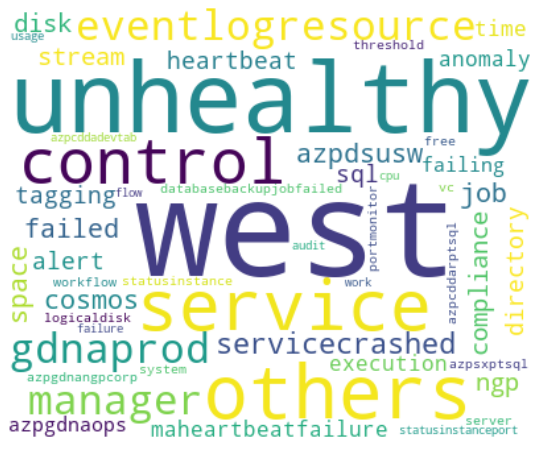

In [14]:
from wordcloud import WordCloud

#Generate word cloud based on Count 
wc = WordCloud(width=400, height=330, max_words=50, background_color='white').generate_from_frequencies(tickets_dtm[:].sum())

plt.figure(figsize=(12, 8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
# Putting feature variable to X
X = tickets_dtm.copy()

# Putting response variable to y
y = tickets['DIG_Engineering/Infra_Task']

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [17]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# Running the random forest with default parameters.
rfc = RandomForestClassifier()

In [18]:
# fit
rfc.fit(X_train,y_train)

RandomForestClassifier()

In [19]:
# Making predictions
predictions = rfc.predict(X_test)

In [20]:
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

In [21]:
# Let's check the report of our default model
print(classification_report(y_test,predictions))

                         precision    recall  f1-score   support

      Anomaly Detection       1.00      1.00      1.00         8
       DIG Daily Status       1.00      1.00      1.00         1
      Disk Space alerts       1.00      1.00      1.00         6
Event Monitoring Alerts       1.00      1.00      1.00        11
          NGP Blacklist       1.00      1.00      1.00         1
     Performance Alerts       1.00      1.00      1.00         9
          SQL Incidents       1.00      1.00      1.00         9
  Service Status Alerts       1.00      1.00      1.00        17
         Stream Tagging       1.00      1.00      1.00         5
  Top 10 High Cost Jobs       1.00      1.00      1.00         2
       Top Failing Jobs       1.00      1.00      1.00         2
  Xflow Repeat Failures       1.00      1.00      1.00         5

               accuracy                           1.00        76
              macro avg       1.00      1.00      1.00        76
           weighted avg

In [22]:
# Printing confusion matrix
print(confusion_matrix(y_test,predictions))

[[ 8  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  6  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 11  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  9  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  9  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 17  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  5  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  5]]


In [23]:
print(accuracy_score(y_test,predictions))

1.0


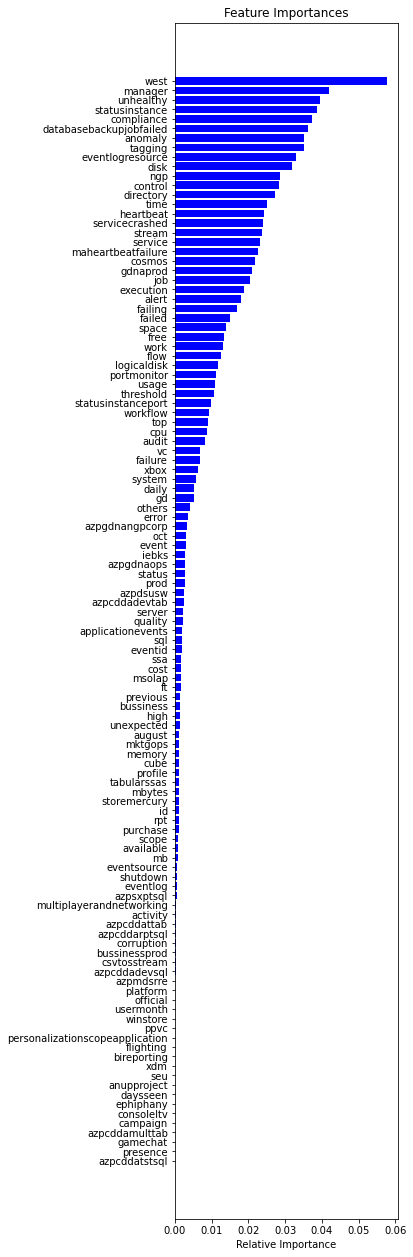

In [24]:
# To find which words(features) are impoerant
features = X_train.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(4,22))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer(min_df=2)

In [27]:
tickets_TFD = cv.fit_transform(tickets['Title'])
tickets_TFD

<376x115 sparse matrix of type '<class 'numpy.float64'>'
	with 2625 stored elements in Compressed Sparse Row format>

In [28]:
tickets_dtm1=pd.DataFrame(cv.fit_transform(tickets['Title']).toarray(), columns=cv.get_feature_names()) # 

In [29]:
tickets_dtm1

,activity,alert,anomaly,anupproject,applicationevents,audit,august,available,azpcddadevsql,azpcddadevtab,...,unhealthy,usage,usermonth,vc,west,winstore,work,workflow,xbox,xdm
0,0.000000,0.000000,0.464303,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.464303,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.464303,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.464303,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.00000,0.000000,0.324959,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.493516,0.000000,0.000000,0.000000,0.324959,0.307634,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.00000,0.000000,0.420932,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.420932,0.398490,0.000000,0.000000
6,0.000000,0.000000,0.464303,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.464303,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.381863,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.464303,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [30]:
# Putting feature variable to X
X1 = tickets_dtm1.copy()

# Putting response variable to y
y1 = tickets['DIG_Engineering/Infra_Task']

# Splitting the data into train and test
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=100)

In [31]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# Running the random forest with default parameters.
rfc1 = RandomForestClassifier()

In [32]:
# fit
rfc1.fit(X1_train,y1_train)

RandomForestClassifier()

In [33]:
# Making predictions
predictions1 = rfc1.predict(X1_test)

In [34]:
# Let's check the report of our default model
print(classification_report(y1_test,predictions1))

                         precision    recall  f1-score   support

      Anomaly Detection       1.00      1.00      1.00         8
       DIG Daily Status       1.00      1.00      1.00         1
      Disk Space alerts       1.00      1.00      1.00         6
Event Monitoring Alerts       1.00      1.00      1.00        11
          NGP Blacklist       1.00      1.00      1.00         1
     Performance Alerts       1.00      1.00      1.00         9
          SQL Incidents       1.00      1.00      1.00         9
  Service Status Alerts       1.00      1.00      1.00        17
         Stream Tagging       1.00      1.00      1.00         5
  Top 10 High Cost Jobs       1.00      1.00      1.00         2
       Top Failing Jobs       1.00      1.00      1.00         2
  Xflow Repeat Failures       1.00      1.00      1.00         5

               accuracy                           1.00        76
              macro avg       1.00      1.00      1.00        76
           weighted avg

In [35]:
# Printing confusion matrix
print(confusion_matrix(y1_test,predictions1))

[[ 8  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  6  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 11  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  9  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  9  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 17  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  5  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  5]]


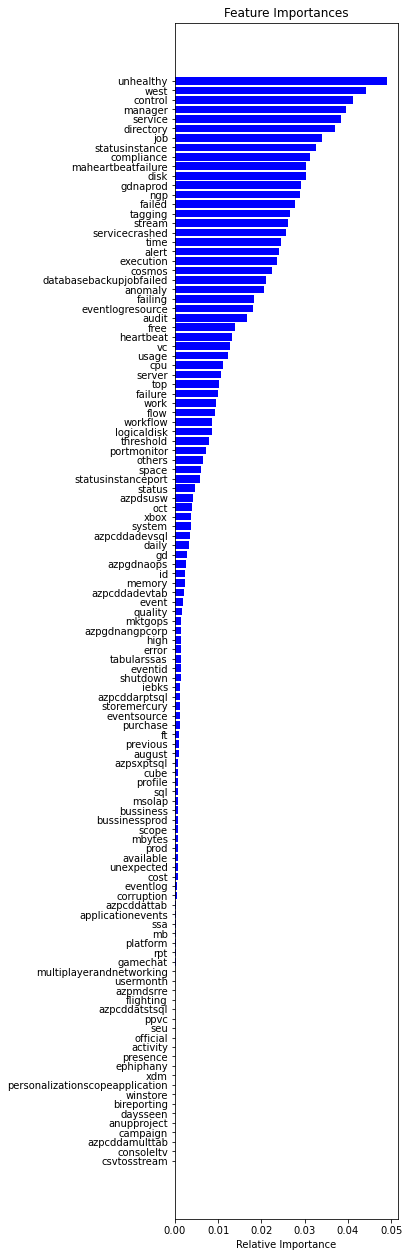

In [36]:
# To find which words(features) are impoerant
features = X1_train.columns
importances = rfc1.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(4,22))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()